In [25]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [26]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=10)
#
client = Client(cluster)

In [27]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

In [28]:
parcels_index = 'lpass_filtered_05cpd'
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df.head()


,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,waterdepth,zonal_velocity_hat_real,zonal_velocity_hat_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag
time,,,,,,,,,,,
2011-11-15,2000844,-67.226303,0.562500,0.0,0.0,0.0,0.0,-0.037399,0.0,-0.038937,0.0
2011-11-15,2001062,-68.788177,10.979167,0.0,0.0,0.0,0.0,-0.050828,0.0,-0.055424,0.0
2011-11-15,2001076,-62.904213,10.979167,0.0,0.0,0.0,0.0,-0.052928,0.0,-0.013808,0.0
2011-11-15,3001600,-60.772732,31.812500,0.0,0.0,0.0,0.0,0.026066,0.0,-0.010228,0.0
2011-11-15,4000298,-28.264765,-23.395834,0.0,0.0,0.0,0.0,-0.037163,0.0,0.025803,0.0


In [5]:
df['zonal_velocity_energy'] = df['zonal_velocity_hat_real'].apply(lambda x : x**2)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_hat_real', 'float64'))

  warnings.warn(meta_warning(meta))


In [6]:
_df = df[['zonal_velocity_energy','lon','lat','waterdepth','trajectory']]
_df.head()

,zonal_velocity_energy,lon,lat,waterdepth,trajectory
time,,,,,
2011-11-15,0.001399,0.562500,-67.226303,0.0,2000844
2011-11-15,0.002583,10.979167,-68.788177,0.0,2001062
2011-11-15,0.002801,10.979167,-62.904213,0.0,2001076
2011-11-15,0.000679,31.812500,-60.772732,0.0,3001600
2011-11-15,0.001381,-23.395834,-28.264765,0.0,4000298


### Load Eulerian dataset

In [35]:
ds_low = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_lf.zarr')
grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]
ds_low['lon'] = 0*ds_low.face+grd.XC
ds_low['lat'] = 0*ds_low.face+grd.YC
ds

/dev/shm/pbs.9820106.datarmor0/ipykernel_40347/261041431.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]


<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i: 4320, time: 8640)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SSU_rot  (time, face, j, i) float32 dask.array<chunksize=(240, 1, 192, 576), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [11]:
ds_low.lat.rename('lat').compute()

<xarray.DataArray 'lat' (face: 13, j: 1080, i: 1080)>
array([[[-88.17714691, -88.18882751, -88.20050812, ..., -80.42420197,
         -80.41905212, -80.4139328 ],
        [-88.1770401 , -88.1887207 , -88.20040131, ..., -80.42417908,
         -80.41902924, -80.41390991],
        [-88.17676544, -88.18844604, -88.20011902, ..., -80.4241333 ,
         -80.41898346, -80.41386414],
        ...,
        [-57.1337738 , -57.1337738 , -57.1337738 , ..., -57.1337738 ,
         -57.1337738 , -57.1337738 ],
        [-57.08955002, -57.08955002, -57.08955002, ..., -57.08955002,
         -57.08955002, -57.08955002],
        [-57.04529953, -57.04529953, -57.04529953, ..., -57.04529953,
         -57.04529953, -57.04529953]],

       [[-57.00102615, -57.00102615, -57.00102615, ..., -57.00102615,
         -57.00102615, -57.00102615],
        [-56.95672226, -56.95672226, -56.95672226, ..., -56.95672226,
         -56.95672226, -56.95672226],
        [-56.91239929, -56.91239929, -56.91239929, ..., -56.91239929,
         -56.91239929, -56.91239929],
...
        [ 13.72816563,  13.65358448,  13.57897758, ..., -56.87913895,
         -56.92348099, -56.96780014],
        [ 13.72816563,  13.65358448,  13.57897758, ..., -56.87913895,
         -56.92348099, -56.96780014],
        [ 13.72816563,  13.65358448,  13.57897758, ..., -56.87913895,
         -56.92348099, -56.96780014]],

       [[-57.01209641, -57.05636597, -57.10060883, ..., -80.40871429,
         -80.40879059, -80.40882874],
        [-57.01209641, -57.05636597, -57.10060883, ..., -80.40364838,
         -80.40372467, -80.40376282],
        [-57.01209641, -57.05636597, -57.10060883, ..., -80.39862061,
         -80.39868927, -80.39872742],
        ...,
        [-57.01209641, -57.05636597, -57.10060883, ..., -88.14142609,
         -88.14181519, -88.14204407],
        [-57.01209641, -57.05636597, -57.10060883, ..., -88.15309906,
         -88.15349579, -88.15372467],
        [-57.01209641, -57.05636597, -57.10060883, ..., -88.16477203,
         -88.16517639, -88.16540527]]])
Coordinates:
    XC       (face, j, i) float32 -114.9 -114.9 -114.9 ... -113.5 -114.0 -114.5
    YC       (face, j, i) float32 -88.18 -88.19 -88.2 ... -88.16 -88.17 -88.17
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

### Binning

In [36]:
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

In [21]:
ds_low = ds_low.chunk({'i':1,'j':1})

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/nanny.py", line 931, in _run
    loop.run_sync(run)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/asyncio/base_events.py", line 1823, in _run_once
    event_list = self._selector.select(timeout)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/selectors.py", line 468, in select
    fd_event_list = self._selector.poll(timeout, max_ev)
Keybo

In [22]:
ds_low

,Array,Chunk
Bytes,57.84 MiB,44 B
Shape,"(13, 1080, 1080)","(11, 1, 1)"
Count,4665603 Tasks,2332800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,57.84 MiB,44 B
Shape,"(13, 1080, 1080)","(11, 1, 1)"
Count,4665603 Tasks,2332800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [37]:
N = histogram(ds_low.lon.rename('lon'), ds_low.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

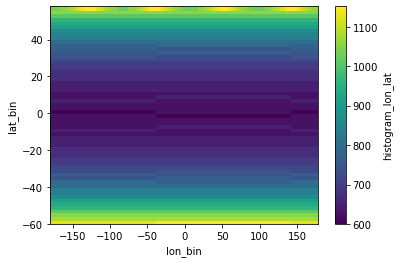

In [38]:
N.plot(y='lat_bin')

In [39]:
ds_binned = (histogram(ds_low.lon.rename('lon'), ds_low.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=ds_low.energy.fillna(0.),
                       dim=['i', 'j', 'face'])/(N)).rename('E_energy').persist()

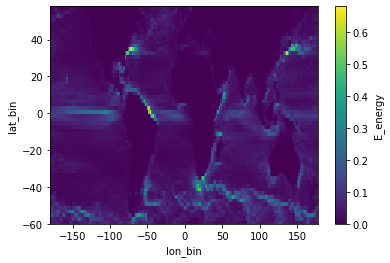

In [40]:
ds_binned.plot(y='lat_bin')

In [20]:
def binning(_df,binsize):
    #lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = _df['lon'].map_partitions(pd.cut, bins=lon_bins)
    _df['lat_cut'] = _df['lat'].map_partitions(pd.cut, bins=lat_bins)
    _df = _df.drop(columns=['lon','lat','trajectory']) # ,'h'
    return _df
df = binning(df,dl).persist()

In [ ]:
df_mean = df.groupby(['lon_cut','lat_cut']).mean()
df_mean = df_mean.reset_index().persist()

In [ ]:
df_mean['lon_bins'] = df_mean.lon_cut.apply(lambda x :x.mid)
df_mean['lat_bins'] = df_mean.lat_cut.apply(lambda x :x.mid)
df_mean = df_mean.drop(columns=['lon_cut','lat_cut']).persist()
df_mean.head()

In [ ]:
df_mean = df_mean.compute()

In [ ]:
dsL = df_mean.set_index(['lon_bins','lat_bins']).to_xarray().unstack()

In [41]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/